In [1]:
%env CUDA_VISIBLE_DEVICES = 7
%load_ext autoreload

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T

from batchflow.models.torch import *

import models
from utils import train_procedure, AdeDataset, get_ade_transforms, load_model

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
SAVES_PATH = "saves"
device = torch.device('cuda')
batch_size = 12
use_pretrained_encoder = True 
encoder_ckpt_path = 'saves/ckpts3/densenet_staged_model.pt'

In [4]:
transform = get_ade_transforms(resize=512)
train_dataset = AdeDataset(transform=transform, mode='training', )
val_dataset = AdeDataset(transform=transform, mode='validation')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True) 

In [5]:
densenet = models.DenseNet(k_factor=12, num_units_collection=(3, 6, 12, 8))
if use_pretrained_encoder:
    _ = load_model(model=densenet, ckpt_path=encoder_ckpt_path)
densenet.layers['head'] = nn.Identity()

In [32]:
config = {
    'inputs_shapes': (3, 512, 512),
    
    'order': ['encoder', 'decoder', 'head'],
    
    'encoder': {'type': 'wrapper', 'module': densenet},
    
    'decoder': {
        'skip': True,
        'indices':  [-3, -4, -5],
        'type': 'decoder',
        'num_stages': 3,
        'order': ['block', 'combine'],
        'blocks': {'layout': 'nat', 'channels': [97, 51, 30],
                   'scale_factor': [1, 2, 2],
                   'kernel_size': [1, 2, 2], 
                   'stride': [1, 2, 2],
                  },
        'combine': {'op': 'sum', 'force_resize': False},
    },
    'head': {
        'layout': 'nat', 'channels': 151, 'kernel_size': 8, 'stride': 8,
    },
    
    'loss': 'ce', 
    'microbatch': None,
    'device': 'gpu:0',
}

batchflow_model = TorchModel(config)
batchflow_model.repr(2)

Network(
    (encoder:  (?,   3, 512, 512)  ⟶ [(?,  30,  64,  64),
                                       (?,  51,  32,  32),
                                       (?,  97,  16,  16),
                                       (?, 193,  16,  16),
                                       (?, 193,  16,  16)])
    (decoder): DecoderModule(
        (block-0:    (?, 193,  16,  16)  ⟶ (?,  97,  16,  16))
        (combine-0: [(?,  97,  16,  16),
                     (?,  97,  16,  16)] ⟶ (?,  97,  16,  16))
        (block-1:    (?,  97,  16,  16)  ⟶ (?,  51,  32,  32))
        (combine-1: [(?,  51,  32,  32),
                     (?,  51,  32,  32)] ⟶ (?,  51,  32,  32))
        (block-2:    (?,  51,  32,  32)  ⟶ (?,  30,  64,  64))
        (combine-2: [(?,  30,  64,  64),
                     (?,  30,  64,  64)] ⟶ (?,  30,  64,  64))
    )
    (head:     (?,  30,  64,  64)  ⟶ (?, 151, 512, 512))
)


In [29]:
my_model = models.FCN(num_classes=151, k_factor=12, num_units_collection=(3, 6, 12, 8), pretrained=False)

In [31]:
inputs = torch.randn(1, 3, 512, 512)
out = my_model(inputs)

torch.Size([1, 51, 32, 32])
torch.Size([1, 51, 32, 32])


In [7]:
my_model = models.FCN(num_classes=151, k_factor=12, num_units_collection=(3, 6, 12, 8), pretrained=False)

torch_model_params = sum(p.numel() for p in my_model.parameters() if p.requires_grad)
batchflow_model_params = sum(p.numel() for p in batchflow_model.model.parameters() if p.requires_grad)
del my_model

print(f'batchflow #params: {batchflow_model_params}, torch #params: {torch_model_params}')

batchflow #params: 727182, torch #params: 727182


In [8]:
N_EPOCHS = 30
RESUME_TRAINING = False

model_name = 'batchflow_fcn'
epoch = 0

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchflow_model.model.parameters(), lr=1e-5)

if RESUME_TRAINING:
    epoch = load_model(batchflow_model.model, optimizer=optimizer, device=device, ckpt_path=os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-8)

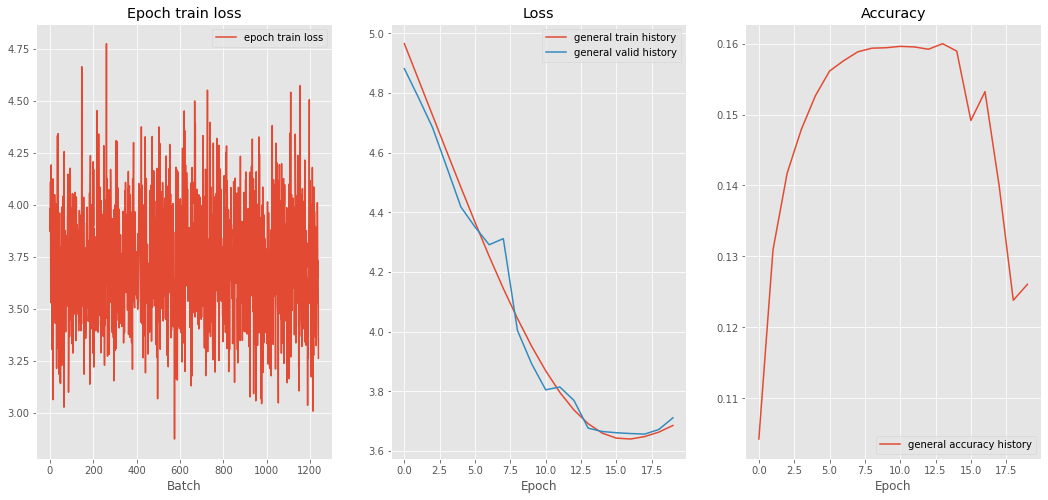

In [ ]:
train_procedure(n_epochs=N_EPOCHS, model=batchflow_model.model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name,
               segmentation=True)

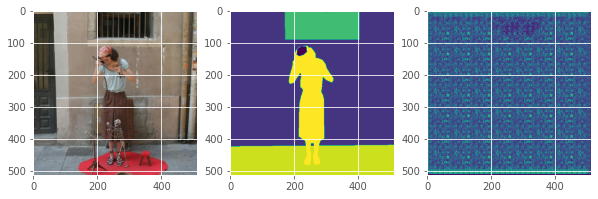

In [18]:
mean=[125, 119, 110]
std=[57, 57, 61]

renorm = T.Compose(
    [T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
     T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
     T.ToPILImage(mode='RGB')])

imgs, targets = next(iter(val_dataloader))
img = imgs[0, ...]
trg = targets[0, ...]

batchflow_model.model.eval()
with torch.no_grad():
    outputs = batchflow_model.model(imgs.to(device))
    outputs = outputs.detach().cpu()
    out = outputs[0, ...].argmax(axis=0)

img.shape, trg.shape
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 15))
ax1.imshow(renorm(img))
ax2.imshow(trg)
ax3.imshow(out)